In [75]:
%load_ext autoreload
%autoreload 2
#%pip list
import sys
import pandas as pd
import numpy as np
import re
import transformers
from sklearn.preprocessing import LabelEncoder
import os
import re
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%pip install numpy torchvision --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __getitem__(self, idx):
        sentence = self.data.loc[idx].text
        sentence = self.tokenizer(sentence,    padding='max_length', truncation=True,max_length=self.maxLen)['input_ids']
        label = self.data.loc[idx].food
        return torch.tensor(sentence),label
 
    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())

In [78]:
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
maxLen = 32
batchSize = 512
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train samples  = {trainData.__len__()}')
#trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData,batch_size=testData.__len__(),shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train samples  = 67972
Number of test data points = 22716


In [79]:
data = next(iter(trainLoader))
print(data[0][0:2])
print(data[1][0:2])

tensor([[ 4561,   259,   620,    12, 29988,  1496, 13388,   351,  2297, 20920,
           286,  2629, 14002,  3467, 27705,    17,    59,    87,  1795,    59,
            87,  6052, 44229,  3467, 27705,    17,    59,    87,  1795,    59,
            87,  6052],
        [14539,  2787,   316, 26694,   532,  1126,  1326, 18145,  7197, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257]])
('mussels', 'chocolate_mousse')


# Convert categorical labels to numerical labels

In [80]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[1]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}

In [81]:
class w2nModel(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses, padId):
        super(w2nModel, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()
        self.padId = padId

    def forward(self, x_):
        x = self.word_embeddings(x_) # input dimensions are (batch size, sqeuenquence length) - output dimensions are (batch size, sequence length, feature size)
        x[x_ == self.padId,:] = 0 # set rows, where each row is of dimension equal to feature size, corresponding to pad id = 0
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :] # gives two dimensional output, not three dimensional output -  we are retaining the last hidden state                        
        x = self.drop1(x)               
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

# Training

In [82]:
import numpy
from transformers import GPT2Config
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
hidden_size = 64
padId = tokenizer(tokenizer.pad_token)['input_ids'][0]
dModel = 100
config = GPT2Config()
vocabSize = config.vocab_size
numClasses = 101
model = w2nModel(vocab_size = vocabSize+1, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses, padId = padId
                )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
lossVals = []
model = model.to(device)
print(model)

cpu
w2nModel(
  (word_embeddings): Embedding(50258, 100)
  (LSTM): LSTM(100, 64, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (FC1): Linear(in_features=64, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=256, out_features=101, bias=True)
  (Relu): ReLU()
)


In [83]:
for epoch in range(35):  # loop over the dataset multiple times
    for data in trainLoader:
        inputs,labels_ = data
        #labels = []
        #labels.append([lblMap[x] for x in labels_])
        #labels = torch.tensor(labels[0])
        #inputs = inputs.to(device) 
        #labels = labels.to(device)
        labels = torch.tensor([lblMap[x] for x in labels_])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().cpu().clone().numpy())
        optimizer.step()
    if epoch%1 == 0:
        print(loss)
print('Finished Training')

tensor(4.5705, grad_fn=<NllLossBackward0>)
tensor(4.4978, grad_fn=<NllLossBackward0>)
tensor(4.3462, grad_fn=<NllLossBackward0>)
tensor(4.0476, grad_fn=<NllLossBackward0>)
tensor(2.9443, grad_fn=<NllLossBackward0>)
tensor(2.0561, grad_fn=<NllLossBackward0>)
tensor(1.6322, grad_fn=<NllLossBackward0>)
tensor(1.2631, grad_fn=<NllLossBackward0>)
tensor(1.0649, grad_fn=<NllLossBackward0>)
tensor(0.9617, grad_fn=<NllLossBackward0>)
tensor(0.9958, grad_fn=<NllLossBackward0>)
tensor(0.9301, grad_fn=<NllLossBackward0>)
tensor(0.8959, grad_fn=<NllLossBackward0>)
tensor(0.9526, grad_fn=<NllLossBackward0>)
tensor(0.9889, grad_fn=<NllLossBackward0>)
tensor(0.7951, grad_fn=<NllLossBackward0>)
tensor(0.9189, grad_fn=<NllLossBackward0>)
tensor(0.7686, grad_fn=<NllLossBackward0>)
tensor(0.8670, grad_fn=<NllLossBackward0>)
tensor(0.8632, grad_fn=<NllLossBackward0>)
tensor(0.8474, grad_fn=<NllLossBackward0>)
tensor(0.6746, grad_fn=<NllLossBackward0>)
tensor(0.7486, grad_fn=<NllLossBackward0>)
tensor(0.67

# Test Neural Net

In [84]:
# again no gradients needed
model.eval()
correct_pred = 0
numTst = 0
with torch.no_grad():
    for data in testLoader:
        inputs, labels_ = data
        numTst = numTst + inputs.shape[0]
        labels = []
        labels.append([lblMap[x] for x in labels_])
        labels = torch.tensor(labels[0])

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1

accuracy = 100 * float(correct_pred)/ numTst
print(numTst)
print(f"Classification Accuracy is {accuracy:.3f}%")

22716
Classification Accuracy is 82.096%


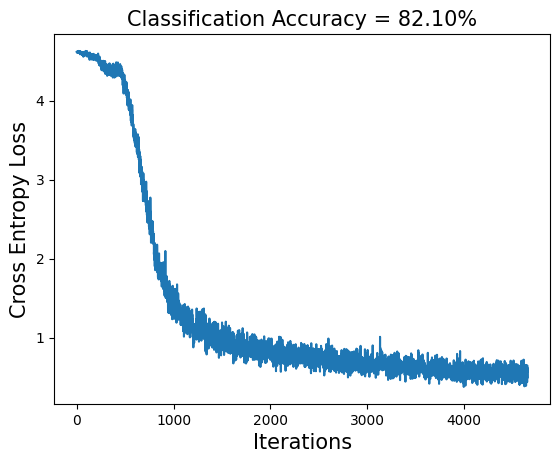

In [85]:
import numpy as np
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dModel,accuracy, maxLen,hidden_size)
plt.savefig(path+'.pdf')

### Get 5 Most Error-Full Classes

In [86]:
path = os.getcwd()
checkpoint_path = path+'\_accrcy_{:.2f}_dim_{}.pt'.format(accuracy,dModel)
print(checkpoint_path)
torch.save(model, checkpoint_path)

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
C:\Users\vm-user\AppData\Local\Temp\ipykernel_6504\2978387619.py:2: SyntaxWarning: invalid escape sequence '\_'
  checkpoint_path = path+'\_accrcy_{:.2f}_dim_{}.pt'.format(accuracy,dModel)


c:\Users\vm-user\Documents\GitHub\Food_101\_accrcy_82.10_dim_100.pt


# SVM with LSTM 
### No Fully Connected Layers - just training SVM on LSTM outptut

## Declare LSTM model - no Fully Connected Layers

In [87]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)

    def forward(self, x):
        x = self.word_embeddings(x)     # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :]                 # gives two dimensional output, not three dimensional output
        return x

modelSVM = w2nModelSVM(vocab_size = vocabSize+1, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelSVM.word_embeddings.weight.data.copy_((model.word_embeddings.weight))
modelSVM.LSTM.weight.data.copy_((model.LSTM.weight))
#modelSVM.word_embeddings.weight.requires_grad=False
#modelSVM.LSTM.load_state_dict(model.LSTM.state_dict())


## Get LSTM Embeddings for Train and Test Dataset

In [88]:
numTrn = trainData.__len__()
trnEmbdngs = np.zeros((numTrn,hidden_size))
trnLbls  = []
modelSVM.eval()
for i, data in enumerate(trainLoader):
    inputs,labels_ = data
    outputs = modelSVM(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls = trnLbls + [lblMap[x] for x in labels_]

numTst = testData.__len__()
tstEmbdngs = np.zeros((numTst,hidden_size))
tstLbls = [] 
for i, data in enumerate(testLoader):
    inputs,labels_ = data
    labels =  []
    outputs = modelSVM(inputs)
    tstEmbdngs = outputs.detach().clone().numpy()
    tstLbls = tstLbls + [lblMap[x] for x in labels_]

## Accuracy using Linear SVM


In [89]:
from sklearn import svm
print(len(trnLbls))
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, np.asarray(trnLbls))
TrnAccrcyLnr = clf.score(trnEmbdngs, np.asarray(trnLbls))
TstAccrcyLnr = clf.score(tstEmbdngs,np.asarray(tstLbls))
print(r'Train Accuracy of Linear SVM =', 100*TrnAccrcyLnr)
print(TstAccrcyLnr)
print(r'Test Accuracy of Linear SVM =', 100*TstAccrcyLnr)


67972
Train Accuracy of Linear SVM = 0.4662508091567116
0.4367406233491812


## Accuracy using RBF Kernel SVM

In [90]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKrnl = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKrnl = clf.score(tstEmbdngs,tstLbls)
print(r'Train Accuracy of Kernel SVM =', 100*TrnAccrcyKrnl)
print(TstAccrcyKrnl)
print(r'Test Accuracy of Kernel SVM =', 100*TstAccrcyKrnl)

0.39161713646795737
0.36489698890649763
